In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array


2025-09-30 23:08:56.630565: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/mac/Desktop/Projects/Python/CourseWork2/LICENSEPLATERECOGNITION/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# !pip install pytesseract
# !pip install plotly
# !pip install scikit-image

In [3]:
path = glob('./data/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [4]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

filepath  xmin  xmax  ymin  ymax
0  ./data/162.xml   166   333   459   542
1   ./data/88.xml   263   343   297   344
2  ./data/176.xml   157   342   510   549
3   ./data/63.xml   180   219   122   143
4   ./data/77.xml   583   674   357   419

With the above code, we successfully extract the diagonal position of each image and convert the data from an unstructured to a structured format.You can have A look data above. Now also extract the respective image filename of the XML.

In [5]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('./data/',filename_image)
    return filepath_image
getFilename(filename)

'./data/162.jpg'

In [6]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]#random check

['./data/162.jpg',
 './data/88.jpg',
 './data/176.jpg',
 './data/63.jpg',
 './data/77.jpg',
 './data/189.jpg',
 './data/214.jpg',
 './data/200.jpg',
 './data/228.jpg',
 './data/229.jpg']

In [7]:
file_path = image_path[87] #path of our image N2.jpeg
img = cv2.imread(file_path) #read the image
# xmin-1804/ymin-1734/xmax-2493/ymax-1882 
img = io.imread(file_path) #Read the image
fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 8 - N2.jpeg with bounding box')
fig.add_shape(type='rect',x0=1804, x1=2493, y0=1734, y1=1882, xref='x', yref='y',line_color='cyan')

In [8]:
#Targeting all our values in array selecting all columns
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

After that, we will normalize the image just by dividing with maximum number as we know that the maximum number for an 8-bit image is 28 -1 = 255. That the reason we will divide our image 255.0. The way of diving an array with the maximum value is called Normalization (Min-Max Scaler). We also need to normalize our labels too. Because for the deep learning model the output range should be between 0 to 1. For normalizing labels, we need to divide the diagonal points with the width and height of the image. And finally values in a python list.
<p id="part13"></p>

# <span style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color: #000000; line-height:1.0">3.2 SPLIT TRAIN AND TEST SET</span>
In the next step, we will convert the list into an array using __Numpy__.

In [9]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

Now split the data into training and testing set using __sklearn__.

In [10]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((200, 224, 224, 3), (50, 224, 224, 3), (200, 4), (50, 4))

<p id="part14"></p>

# <span style="font-family: Arials; font-size: 20px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color: #000000; line-height:1.0">4. DEEP LEARNING FOR OBJECT DETECTION </span>

<p id="part15"></p>

# <span style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color: #000000; line-height:1.0">4.1 INCEPTION-RESNET-V2 MODEL BUILDING</span>

Inception-ResNet-v2 is a convolutional neural network that is trained on more than a million images from the ImageNet database. The network is 164 layers deep and can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The Inception-ResNet-v2 was used for the classification task. The architecture of the network is shown in Figure 9 . Inception-Resnet-v2 is formulated based on a combination of the Inception structure and the Residual connection. In the Inception-Resnet block multiple sized convolutional filters are combined by residual connections. The usage of reyfual connections not only avoids the degradation problm caused by deep structures but also reduces the training time.

<img src= "https://github.com/Asikpalysik/Automatic-License-Plate-Detection/blob/main/Presentation/Notebook7.png?raw=true" width="50%" align="center"  hspace="5%" vspace="5%"/>

We are ready to train a deep learning model for object detection. Here we will use the Inception-ResNet-v2 model with pre-trained weights and train this to our data. We are already import necessary libraries from TensorFlow previously, lets continue.


In [11]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

Now compile the model and  have a look at our summary. Don't de surprise summary will be a bit massiv. The summary is textual and includes information about: The layers and their order in the model. The output shape of each layer. The number of parameters (weights) in each layer.

In [12]:
# Complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

<p id="part16"></p>

# <span style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color: #000000; line-height:1.0">4.2 INCEPTION-RESNET-V2 TRAINING AND SAVE</span>

In [13]:
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=10,
                    validation_data=(x_test,y_test),callbacks=[tfb])

Epoch 1/10
20/20 [==============================] - 339s 13s/step - loss: 0.0359 - val_loss: 0.0373
Epoch 2/10
20/20 [==============================] - 196s 10s/step - loss: 0.0120 - val_loss: 0.0240
Epoch 3/10
20/20 [==============================] - 196s 10s/step - loss: 0.0076 - val_loss: 0.0184
Epoch 4/10
20/20 [==============================] - 210s 11s/step - loss: 0.0056 - val_loss: 0.0206
Epoch 5/10
20/20 [==============================] - 215s 11s/step - loss: 0.0052 - val_loss: 0.0144
Epoch 6/10
20/20 [==============================] - 204s 10s/step - loss: 0.0041 - val_loss: 0.0137
Epoch 7/10
20/20 [==============================] - 186s 9s/step - loss: 0.0036 - val_loss: 0.0108
Epoch 8/10
20/20 [==============================] - 178s 9s/step - loss: 0.0025 - val_loss: 0.0101
Epoch 9/10
20/20 [==============================] - 201s 10s/step - loss: 0.0019 - val_loss: 0.0097
Epoch 10/10
20/20 [==============================] - 248s 12s/step - loss: 0.0021 - val_loss: 0.0090


In [23]:
model.save('./object_detection.h5')

/Users/mac/Desktop/Projects/Python/CourseWork2/LICENSEPLATERECOGNITION/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



<p id="part17"></p>

# <span style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color: #000000; line-height:1.0">4.3 TENSORBOARD</span>

Lest have a look at on scalars on TensorBoard. In order to do it we will need to run simple command with right path for our "object detection". After we will see output with hosted link open it with Chrome. I was using VSCode for this project and for me it was way easy to run TensorBoard overview results, but in Kaggle it a bit more complicated and could  be disscused in other topic. For now i will show one screenshot of result which we have. We can see on scalars *Figure 12* how is our model preform. Our train and validation set don’t have over fitting behavior and our loss with respect of epochs is less.

You can simple type <code>!tensorboard --logdir="./object_detection"</code> it will generate link with text, click on link and here we go. <code>Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all TensorBoard 2.6.0 at http://localhost:6006/ (Press CTRL+C to quit)</code>

<img src= "https://github.com/Asikpalysik/Automatic-License-Plate-Detection/blob/main/Presentation/Notebook8.png?raw=true" width="80%" align="center" hspace="5%" vspace="5%"/>

<p id="part18"></p>

# <span style="font-family: Arials; font-size: 20px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color: #000000; line-height:1.0">5. PIPELINE OBJECT DETECTION MODEL</span>

<p id="part19"></p>

# <span style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color: #000000; line-height:1.0">5.1 MAKE PREDICTIONS</span>

This is the final step in object detection. In this step, we will put it all together and get the prediction for a given image. First, I would like to try with one of my test pictures of car. Let load our model.

In [ ]:
# Load model
model = tf.keras.models.load_model('./object_detection.h5')
print('Model loaded Sucessfully')

Next is loading our TEST picture with right path to it. I loaded some more images for this purpose  only - folder __TEST__.

In [15]:
path = './test/1.jpg'
image = load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0  # Convert into array and get the normalized output

# Size of the orginal image
h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)


Height of the image = 768
Width of the image = 576


Now we can have a look at our image *Figure 13*

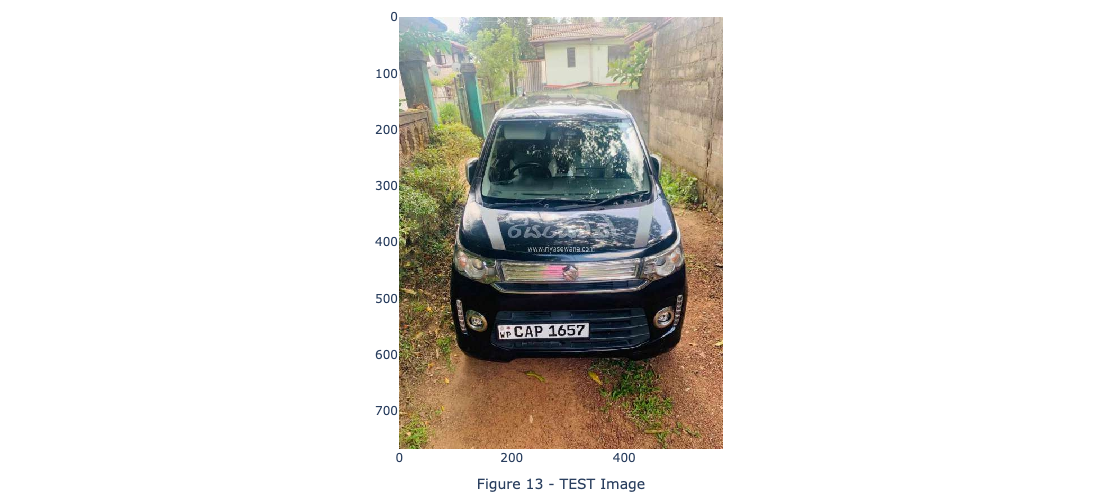

In [16]:
fig = px.imshow(image)
fig.update_layout(width=700, height=500,  margin=dict(l=10, r=10, b=10, t=10), xaxis_title='Figure 13 - TEST Image')

So, let's look into the shape of my image.

In [17]:
image_arr_224.shape

(224, 224, 3)

But in order to pass this image of a model, we need to provide the data in the dynamic fourth dimension. And what one indicates is a number of images. So here we are just passing only one image.

In [18]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

<p id="part20"></p>

# <span style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color: #000000; line-height:1.0">5.2 DE-NORMALIZE THE OUTPUT</span>

In [19]:
# Make predictions
coords = model.predict(test_arr)
coords

1/1 [==============================] - 6s 6s/step


array([[0.39885584, 0.6043624 , 0.6576421 , 0.74514323]], dtype=float32)

We have got the output from the model and output what we got is the normalized output. So, what we need to do is to convert back into our original form values, which actually we did in during the training process, in the training process, we have the original form values and convert that normalized one. So basically, we will de-normalize the values back.

In [20]:
# Denormalize the values
denorm = np.array([w,w,h,h])
coords = coords * denorm
coords

array([[229.74096107, 348.11275864, 505.06915283, 572.27000427]])

<p id="part21"></p>

# <span style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color: #000000; line-height:1.0">5.3 BOUNDING BOX</span>

Now we will draw bounding box on top of the image. I just want to provide the two diagonal points. Let's make use of these points and let's draw the rectangle box.

In [21]:
coords = coords.astype(np.int32)
coords

array([[229, 348, 505, 572]], dtype=int32)

In [22]:
# Draw bounding on top the image
xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)

(229, 505) (348, 572)


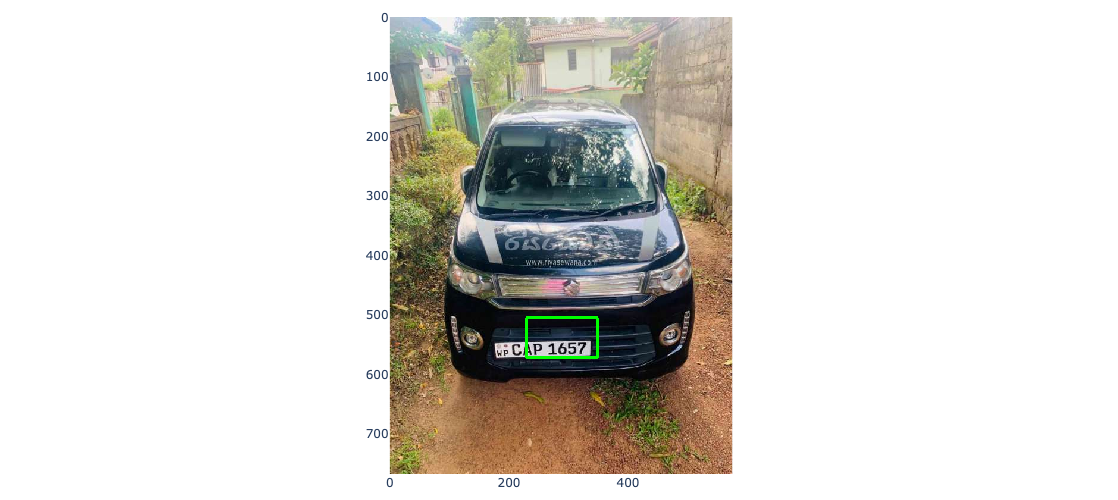

In [23]:
cv2.rectangle(image,pt1,pt2,(0,255,0),3)
fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10))

<p id="part22"></p>

# <span style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color: #000000; line-height:1.0">5.4 CREATE PIPELINE</span>

Now what we'll do, let's put it all together in one place and create function. And in the end visualize it. Our output will return image and coordinates of bounding box.

In [97]:
# Create pipeline
path = './test/2.jpg'
def object_detection(path):
    
    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))
    
    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    
    # Make predictions
    coords = model.predict(test_arr)
    
    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    
    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')

1/1 [==============================] - 1s 587ms/step
(383, 551) (616, 626)


<p id="part23"></p>

# <span style="font-family: Arials; font-size: 20px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color: #000000; line-height:1.0">6. OPTICAL CHARACTER RECOGNITION - OCR</span>
<hr style="height: 0.5px; border: 0; background-color: #000000">

<p id="part24"></p>

# <span style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color: #000000; line-height:1.0">6.1 TESSERACT OCR</span>

Optical character recognition (OCR) software that is used to extract text from the image. Tesseract OCR have a python API and it is open source. Firstly, we will do installation of it. It pretty simple and depend on you OS. You can find manual and files to download for installation [here](https://guides.library.illinois.edu/c.php?g=347520&p=4121425).

<p id="part25"></p>

# <span style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color: #000000; line-height:1.0">6.2 LIMITATIONS OF PYTESSERACT</span>

Tesseract works best when there is a clean segmentation of the foreground text from the background. In practice, it can be extremely challenging to guarantee these types of setups. There are a variety of reasons you might not get good quality output from Tesseract like if the image has noise on the background. The better the image quality (size, contrast, lightning) the better the recognition result. It requires a bit of preprocessing to improve the OCR results, images need to be scaled appropriately, have as much image contrast as possible, and the text must be horizontally aligned. Tesseract OCR is quite powerful but does have the following limitations.

__Tesseract limitations summed in the list.__
<ul>
  <li>The OCR is not as accurate as some commercial solutions available to us.</li>
  <li>Doesn't do well with images affected by artifacts including partial occlusion, distorted perspective, and complex background.</li>
  <li>It is not capable of recognizing handwriting.</li>
  <li>It may find gibberish and report this as OCR output.</li>
  <li>If a document contains languages outside of those given in the -l LANG arguments, results may be poor.</li>  
  <li>It is not always good at analyzing the natural reading order of documents. For example, it may fail to recognize that a document contains two columns, and may try to join text across columns.</li>
  <li>Poor quality scans may produce poor quality OCR.</li>
  <li>It does not expose information about what font family text belongs to.</li>
</ul>

<p id="part26"></p>

# <span style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color: #000000; line-height:1.0">6.3 EXTRACT NUMBER PLATE TEXT FROM IMAGE</span>

Firstly, we will load our image and convert to array. Crop our bounding box with coordinates of it. We will identify region of interest (ROI) and have look at our cropped image *Figure 15*.

In [98]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]
fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 15 Cropped image')

Obviously, we didn't get the proper text, but at least you can able to get 90 percent of the information. It just an example and again will need to say that as more data than better prediction. We will come to that point in future. What I realize here: First of all we don't have much data, to resolve this problem and I added to this topic more sets almost the same data sets from other kagglers posted recently. Secondly i don't see that this model perfom well be honest with you, but full process which has beed done gave as a chance to undertand concept, we will buld another model with help of YOLO and where we can see how it perfom to conpear our results. Second of of Tesseract, I already explain some limetation of it, but image preproccessing can be another topic and it could even requre to build AI on it. So, now I want you to show how to build simple web and next step after it we will start with new model.

In [41]:
# parsing
def parsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find('filename').text
    filename = f'../input/number-plate-detection/images/{name}'

    # width and height
    parser_size = parser.find('size')
    width = int(parser_size.find('width').text)
    height = int(parser_size.find('height').text)
    
    return filename, width, height
df[['filename','width','height']] = df['filepath'].apply(parsing).apply(pd.Series)
df.head()

filepath  xmin  xmax  ymin  ymax  \
0  ./data/162.xml   166   333   459   542   
1   ./data/88.xml   263   343   297   344   
2  ./data/176.xml   157   342   510   549   
3   ./data/63.xml   180   219   122   143   
4   ./data/77.xml   583   674   357   419   

                                         filename  width  height  
0  ../input/number-plate-detection/images/162.jpg    720     659  
1   ../input/number-plate-detection/images/88.jpg    640     474  
2  ../input/number-plate-detection/images/176.jpg    527     812  
3   ../input/number-plate-detection/images/63.jpg    259     194  
4   ../input/number-plate-detection/images/77.jpg   1280     720

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

threshold = 0.5
y_true_labels = []
y_pred_labels = []

for i in range(len(X_test)):
    y_pred = model.predict(np.expand_dims(X_test[i], axis=0))[0]
    h, w, _ = X_test[i].shape

    # Scale back to original image size
    y_pred_scaled = [int(y_pred[0]*w), int(y_pred[1]*h), int(y_pred[2]*w), int(y_pred[3]*h)]
    y_true_scaled = [int(y_test[i][0]*w), int(y_test[i][1]*h), int(y_test[i][2]*w), int(y_test[i][3]*h)]

    iou_score = iou(y_true_scaled, y_pred_scaled)

    if iou_score >= threshold:
        y_true_labels.append(1)  # ground truth exists
        y_pred_labels.append(1)  # correctly predicted
    else:
        y_true_labels.append(1)  # ground truth exists
        y_pred_labels.append(0)  # missed detection

NameError: name 'X_test' is not defined

Now the next step is let me calculate the center_x, center_y, width and height, which is normalized to width and height. And as well normalize width and height of bounding box.

In [42]:
# center_x, center_y, width , height
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']
df.head()

filepath  xmin  xmax  ymin  ymax  \
0  ./data/162.xml   166   333   459   542   
1   ./data/88.xml   263   343   297   344   
2  ./data/176.xml   157   342   510   549   
3   ./data/63.xml   180   219   122   143   
4   ./data/77.xml   583   674   357   419   

                                         filename  width  height  center_x  \
0  ../input/number-plate-detection/images/162.jpg    720     659  0.346528   
1   ../input/number-plate-detection/images/88.jpg    640     474  0.473438   
2  ../input/number-plate-detection/images/176.jpg    527     812  0.473435   
3   ../input/number-plate-detection/images/63.jpg    259     194  0.770270   
4   ../input/number-plate-detection/images/77.jpg   1280     720  0.491016   

   center_y  bb_width  bb_height  
0  0.759484  0.231944   0.125948  
1  0.676160  0.125000   0.099156  
2  0.652094  0.351044   0.048030  
3  0.682990  0.150579   0.108247  
4  0.538889  0.071094   0.086111

In [48]:
### split the data into train and test
df_train = df.iloc[:200]
df_test = df.iloc[200:]

We will copy each image into the folder train and test and generate .txt which has label info.

In [49]:
train_folder = './yolov5/data_images/train'

values = df_train[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(train_folder,image_name)
    dst_label_file = os.path.join(train_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

test_folder = './yolov5/data_images/test'

values = df_test[['filename','center_x','center_y','bb_width','bb_height']].values
for fname, x,y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(test_folder,image_name)
    dst_label_file = os.path.join(test_folder,txt_name+'.txt')
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f'0 {x} {y} {w} {h}'
    with open(dst_label_file,mode='w') as f:
        f.write(label_txt)
        
        f.close()

FileNotFoundError: [Errno 2] No such file or directory: '../input/number-plate-detection/images/162.jpg'

As well I will create __data.yaml__ file with path to train and validation, as well number of classes as 1, name it in list as license plate. You will need to save this in your dataset because we will need to provide the path on it later.

```
train: data_images/train
val: data_images/test
nc: 1
names: [
    'license_plate'
]
```

In [ ]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()  

In [ ]:
!python ./yolov5/train.py --data ../input/number-plate-detection/data.yaml --cfg ./yolov5/models/yolov5s.yaml --batch-size 8 --name Model --epochs 100

When model trained, we need to save our it in order to use it at OCR in onnx format as below:

In [ ]:
!python ./yolov5/export.py --weight ./yolov5/runs/train/Model/weights/best.pt --include torchscript onnx

All right, we have successfully safed our model after unzip it. We can notice that there is a model folder.
We can find predicted pictures and we are able to detect the license plate very accurately. There might be the few wrong results, but still our model detects the license plate accurately. PR cow is eventually very  important for me that will tell you the detection rate. We can see that our precision recall tell us that we can able to detect our model with 0.92 Precision and 0.5 mean Average Precision, you can find example of one of val_batch below
<img src= "https://github.com/Asikpalysik/Automatic-License-Plate-Detection/blob/main/Presentation/Notebook15.png?raw=true" width="100%" align="center"  hspace="5%" vspace="5%"/>

<p id="part37"></p>

# <span style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color: #000000; line-height:1.0">8.4 PREDICTING RESULTS FROM YOLO</span>

Let’s do some images settings which is omportant to provide in model construction.  Input settings we need to pass as 640 by 640.

In [ ]:
# settings
INPUT_WIDTH =  640
INPUT_HEIGHT = 640

Let me first load TEST image, it will have a plate number on it.

In [ ]:
# LOAD THE IMAGE
img = io.imread('../input/number-plate-detection/TEST/TEST.jpeg')

fig = px.imshow(img)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()

Now, we will load our YOLO model.

In [ ]:
# LOAD YOLO MODEL
net = cv2.dnn.readNetFromONNX('./yolov5/runs/train/Model/weights/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

The next step is I need to parse this image to my YOLO model and get the prediction. Important - size we need to set as input width a 640 and input height is 640.

We have the 25200 rows and 6 columns.  The first four columns will give you the information about the bounding box, which is center X and, Center Y, W and H. And these values are normalized to 640 by 640. And the next two values are the confidence and the probabilities. Confidence tells us what is the confidence for the detecting the bounding box and the next one is the probability score of the class, since we have only one class that is number plate.

Let’s make a list of boxes and confidence and place it order. As well we need to identify our X_factor and Y_factor of image.

We have to filter detections based on the confidence score and the probability score. Let me take the confidence >0.4 and filter from class >0.25.

There is will be one of major issue with YOLO modeling it will give you the repeated boxes, but the same object it might give you that multiple boxes. For that we need to perform the non-maximum suppression. To do it we need to provide all our clean boxes and confidences. 

In the end of that part of code I will take bounding boxes and draw the rectangle box to our image. And will write it all in functions. 

In [ ]:
def get_detections(img,net):
    # 1.CONVERT IMAGE TO YOLO FORMAT
    image = img.copy()
    row, col, d = image.shape

    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image

    # 2. GET PREDICTION FROM YOLO MODEL
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    
    return input_image, detections

def non_maximum_supression(input_image,detections):
    
    # 3. FILTER DETECTIONS BASED ON CONFIDENCE AND PROBABILIY SCORE
    
    # center x, center y, w , h, conf, proba
    boxes = []
    confidences = []

    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        if confidence > 0.4:
            class_score = row[5] # probability score of license plate
            if class_score > 0.25:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # 4.1 CLEAN
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()
    
    # 4.2 NMS
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45)
    
    return boxes_np, confidences_np, index

def drawings(image,boxes_np,confidences_np,index):
    # 5. Drawings
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text(image,boxes_np[ind])


        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+25),(0,0,0),-1)


        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),1)
        cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),1)

    return image

In [ ]:
# predictions flow with return result
def yolo_predictions(img,net):
    # step-1: detections
    input_image, detections = get_detections(img,net)
    # step-2: NMS
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    # step-3: Drawings
    result_img = drawings(img,boxes_np,confidences_np,index)
    return result_img

Here we will not only detect license plate but else extract test from it. We already done it before let’s repeat it again. We will write function. First from bounding box we need to take our x,y,w,h and extract ROI. I place it at top of our functions in drawing part.

In [ ]:
# extrating text
def extract_text(image,bbox):
    x,y,w,h = bbox
    roi = image[y:y+h, x:x+w]
    
    if 0 in roi.shape:
        return 'no number'
    
    else:
        text = pt.image_to_string(roi)
        text = text.strip()
        
        return text

In [ ]:
# test
img = io.imread('../input/number-plate-detection/TEST/TEST.jpeg')
results = yolo_predictions(img,net)

In [ ]:
fig = px.imshow(img)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()

The accuracy of the model is really pretty accurate. However, there are few misclassification, but still our model is performing really well. If you want to get more and more good accuracy, what you have to do is feed more and more data and then you can able to predict very good results. 

<p id="part38"></p>

# <span style="font-family: Arials; font-size: 16px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color: #000000; line-height:1.0">8.5 REAL TIME OBJECT DETECTION</span>

In real time prediction my point is that the detection is very perfect and in order to get very, very good predictions, we need to get very high 4K definition camera so that we can able to extract the text properly.
 
```
cap = cv2.VideoCapture('../input/number-plate-detection/TEST/TEST.mp4')
while True:
    ret, frame = cap.read()
    
    if ret == False:
        print('Unable to read video')
        break
        
    results = yolo_predictions(frame,net)
    
    cv2.namedWindow('YOLO',cv2.WINDOW_KEEPRATIO)
    cv2.imshow('YOLO',results)
    if cv2.waitKey(30) == 27 :
        break
        
cv2.destroyAllWindows()
cap.release()
```
<img src= "https://user-images.githubusercontent.com/91852182/172154404-ccb2a6b5-deb4-4321-91ff-a8f13457b352.gif" width="80%" align="center"  hspace="5%" vspace="5%"/>

<p id="part39"></p>

# <span style="font-family: Arials; font-size: 20px; font-style: normal; font-weight: bold; letter-spacing: 3px; text-align: center; color: #000000; line-height:1.0">9. CONCLUSION</span>
<hr style="height: 0.5px; border: 0; background-color: #000000">


With the increase in the number of vehicles, vehicle tracking has become an important research area for efficient traffic control, surveillance, and finding stolen cars. For this purpose, efficient real-time license plate detection and recognition are of great importance. Due to the variation in the background and font color, font style, size of the license plate, and non-standard characters, license plate recognition is a great challenge in developing countries. To overcome such issues, this study applies a deep-learning strategy to improve license plate recognition efficiency. The collected images have been captured under various lighting/contrast conditions, distance from the camera, varying angle of rotation, and validated to produce a high recognition rate. The approach can be effectively used by law enforcement agencies and private organizations to improve homeland security. Future work may include training and validation of the existing algorithm using the hybrid classifier method and improvement of the robustness of the license plate recognition system in varying weather conditions.

*All files you can find as well on my [GITHUB](https://github.com/Asikpalysik/Automatic-License-Plate-Detection)
If you find this post useful please __UPVOTE__, and if you have any question feel free to [CONTACT ME.](http://aslanahmedov.com)*